# Classifier code for training the datasets

## Generate Datasets

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import time
import sys
#df = pd.read_csv('/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/movementLeftFoot.csv')
#df=(df-df.std())/(df.mean())
path="/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/New_feet/raw/"
if sys.platform.startswith('win'):
    path="C:/Users/dexte/Documents/GitHub/TactileSensor/Code/Data collection/robot/New_feet/raw/"
df = pd.read_csv(path+'carpet_d1.1_raw_L.csv')
#df=(df-df.std())/(df.mean())

print(df.keys())

torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.version.cuda)
print("GPU:",torch.cuda.is_available())


def genDataSet(var):
    X,y=sort_data("carpet_d1.1_raw_L.csv",var)
    X1,y1=sort_data("carpet_d1.1_raw_R.csv",var)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("carpet_d1_raw_L.csv",var)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("carpet_d1_raw_R.csv",var)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("wood_d1_raw_R.csv",var)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("wood_d1_raw_L.csv",var)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    return X,y
def sort_data(name,vibration=True,dir="all"):
    df = pd.read_csv(path+name)
    df=pd.DataFrame(df).fillna(0)
    if vibration:
        ar=[]
        for key in list(df.keys()):
            if key not in ["time_step","x","y","z"]:
                ar.append(df[key])
        x=np.array(ar)
    else: #return without vibration data
        ar=[]
        for key in list(df.keys()):
            if key not in ["time_step","x","y","z","s_1_7","s_2_7"]:
                ar.append(df[key])
        x=np.array(ar)
    if dir=="left":
        ar=[]
        for key in list(df.keys()):
            if key not in ["time_step","x","y","z"] and "s_1" in key:
                ar.append(df[key])
        x=np.array(ar)
    elif dir=="right":
        ar=[]
        for key in list(df.keys()):
            if key not in ["x","y","z"] and "s_2" in key:
                ar.append(df[key])
        x=np.array(ar)
    x=x.T #transpose to have layers
    y=np.array([df['x'],df['y'],df['z']])
    y=y.T
    nan_indices = np.where(np.isnan(y))
    y[nan_indices]=0
    print("X data:",x.shape,"/ny data:",y.shape)
    return x,y

X,y=sort_data("carpet_d1.1_raw_L.csv")
X1,y1=sort_data("carpet_d1.1_raw_R.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("carpet_d1_raw_L.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("carpet_d1_raw_R.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("wood_d1_raw_R.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("wood_d1_raw_L.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

def gen_temporal_data(X_,y_,T):
    X=X_.copy()
    temp_x=np.zeros((X.shape[0]-T,X.shape[1]*T))
    temp_y=np.zeros((X.shape[0]-T,y_.shape[1]))
    for j in range(len(y_)-T): #loop through classes
        ar=[X[j+k] for k in range(T)]
        temp_x[j]=np.concatenate(ar,axis=0)
        temp_y[j]=y_[j]
    x=temp_x
    y=temp_y
    return x, y

def gen_temporal_data_2(X_,y_,T):
    X=X_.copy()
    temp_x=np.zeros((X.shape[0]-T,T,X.shape[1]))
    temp_y=np.zeros((X.shape[0]-T,y_.shape[1]))
    for j in range(len(y_)-T): #loop through classes
        ar=[X[j+k] for k in range(T)]
        temp_x[j]=np.array(ar)
        temp_y[j]=y_[j]
    x=temp_x
    y=temp_y
    return x, y

X_,y_=gen_temporal_data(X,y,60)
print(X_.shape,y_.shape)


import torch
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(SimpleNN, self).__init__()

        # Create a list to store the layers of the neural network
        layers = []

        # Add the input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.Sigmoid())  # You can use other activation functions as well
        #print(layers[0].weight.dtype)
        # Add the hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.Sigmoid())  # You can use other activation functions as well

        # Add the output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))

        # Combine all layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Define the forward pass of the network
        return self.model(x)

# Example usage:
input_size = 10
hidden_sizes = [64, 32]
output_size = 2

# Create an instance of the SimpleNN class
model = SimpleNN(input_size, hidden_sizes, output_size)



Index(['time_step', 'x', 'y', 'z', 's_1_0', 's_1_1', 's_1_2', 's_1_3', 's_1_4',
       's_1_5', 's_1_6', 's_1_7', 's_1_8', 's_1_9', 's_1_10', 's_1_11',
       's_1_12', 's_1_13', 's_1_14', 's_1_15', 's_2_0', 's_2_1', 's_2_2',
       's_2_3', 's_2_4', 's_2_5', 's_2_6', 's_2_7', 's_2_8', 's_2_9', 's_2_10',
       's_2_11', 's_2_12', 's_2_13', 's_2_14', 's_2_15'],
      dtype='object')
11.7
GPU: True
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
(25590, 1920) (25590, 3)


## Classify texture

This section takes in a temporal window of tactile data and classifies which texture it is belonging to

## Classify edges

This section we experiment with a regression model to classify simply where an edge is

In [59]:
filepath="C:/Users/dexte/Documents/GitHub/TactileSensor/Code/Data collection/edges/"
x=np.load(filepath+"xdata.npy")
y=np.load(filepath+"ydata.npy")

x_lin=x.reshape((len(x),3*5))
x_noise=x_lin+np.random.normal(0,10,x_lin.shape)

x=np.concatenate([x_lin,x_noise])
y=np.concatenate([y,y])

x_train=x[0:int(len(x)*0.8)]
y_train=y[0:int(len(x)*0.8)]
x_test=x[int(len(x)*0.8):]
y_test=y[int(len(x)*0.8):]
print(x_lin.shape,y.shape)
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
ridge_model = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
ridge_model.fit(x_train, y_train)

# Make predictions on the test data
Y_pred = ridge_model.predict(x_test)

Y_pred[Y_pred<0.5]=0
Y_pred[Y_pred>=0.5]=1
incorrect=np.sum(Y_pred-y_test)/len(Y_pred)
print("Accuracy test:",1-incorrect)

Y_pred = ridge_model.predict(x_train)

Y_pred[Y_pred<0.5]=0
Y_pred[Y_pred>=0.5]=1
incorrect=np.sum(Y_pred-y_train)/len(Y_pred)
print("Accuracy train:",1-incorrect)

(281, 15) (562, 4)
Accuracy test: 1.0
Accuracy train: 0.9643652561247216


#### Visualise

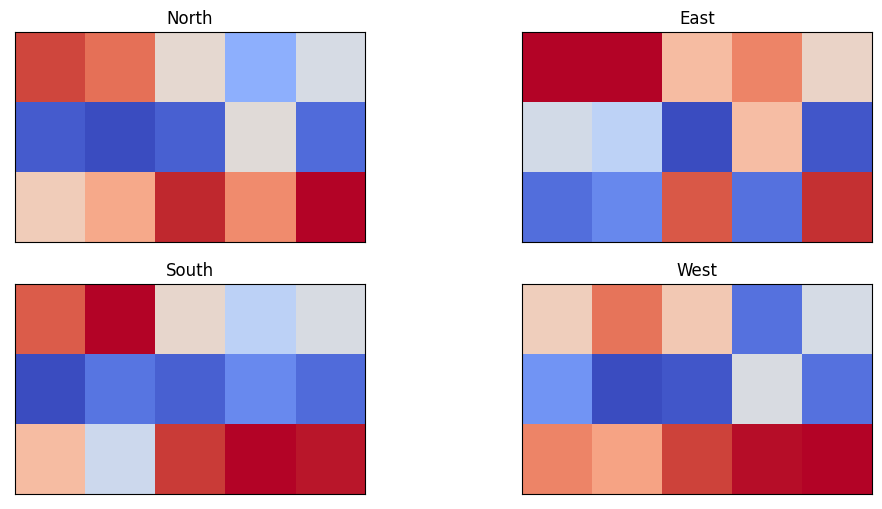

In [74]:
x=np.load(filepath+"xdata.npy")
y=np.load(filepath+"ydata.npy")

mean_values = np.mean(x, axis=1, keepdims=True)
std_dev_values = np.std(x, axis=1, keepdims=True)
x = (x - mean_values) / std_dev_values

n=np.zeros_like(x[0])
s=np.zeros_like(x[0])
w=np.zeros_like(x[0])
e=np.zeros_like(x[0])
for i in range(len(x)):
    if list(y[i])==[1,1,0,0]: n+=x[i]
    elif list(y[i])==[0,1,1,0]: e+=x[i]
    elif list(y[i])==[0,0,1,1]: s+=x[i]
    elif list(y[i])==[1,0,0,1]: w+=x[i]

fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0][0].imshow(n,cmap='coolwarm')
axs[0][0].set_title("North")
axs[0][0].xaxis.set_visible(False)
axs[0][0].yaxis.set_visible(False)

axs[0][1].imshow(e,cmap='coolwarm')
axs[0][1].set_title("East")
axs[0][1].xaxis.set_visible(False)
axs[0][1].yaxis.set_visible(False)

axs[1][0].imshow(s,cmap='coolwarm')
axs[1][0].set_title("South")
axs[1][0].xaxis.set_visible(False)
axs[1][0].yaxis.set_visible(False)

axs[1][1].imshow(w,cmap='coolwarm')
axs[1][1].set_title("West")
axs[1][1].xaxis.set_visible(False)
axs[1][1].yaxis.set_visible(False)

plt.show()

## Classify orientation

Continuing the previous work on classifying what the robots orientation is based off data   